In [1]:
import pickle, os, sys
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes', labelsize='x-large')
plt.rc('font', size=12)

/data/ml2/software/anaconda3/envs/disease_prog/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
with open('1_mmrf_dataset_type.pkl','rb') as f:
    dataset = pickle.load(f)
with open('1_mmrf_dataset_2mos_type.pkl','rb') as f:
    dataset_2mos = pickle.load(f)
print (dataset.keys())
print(dataset['baseline'].keys())
print (dataset_2mos.keys())
print(dataset_2mos['baseline'].keys())

dict_keys(['treatment', 'labs', 'baseline', 'outcomes', 'trt_outcomes'])
dict_keys(['pids', 'data', 'obs', 'names'])
dict_keys(['treatment', 'labs', 'baseline', 'outcomes', 'trt_outcomes'])
dict_keys(['pids', 'data', 'obs', 'names'])


In [3]:
from process_tensors import clean_baseline, clean_labs, get_splits

### Step 1: Restrict all data to share a global ordering over patient ids (from outcomes)
* Plot distribution over outcomes

In [4]:
new_dset = {}
outcomes_type = 'trt_resp' # or 'mortality'

if outcomes_type == 'mortality': 
    new_dset['patient_ids'] = dataset['outcomes']['pids']
    new_dset['y_data']   = dataset['outcomes']['data']
    new_dset['event_obs']= dataset['outcomes']['obs']
elif outcomes_type == 'trt_resp':
    new_dset['patient_ids'] = dataset['trt_outcomes']['pids']
    new_dset['y_data']      = dataset['trt_outcomes']['data']
    new_dset['event_obs']   = dataset['trt_outcomes']['obs']
    new_dset['tr_names']    = dataset['trt_outcomes']['names']
    
pts = new_dset['patient_ids'].tolist()
for k in ['treatment','labs','baseline']:
    pts_src = dataset[k]['pids'].tolist()
    idx_map = np.array([pts_src.index(v) for v in pts])
    new_dset[k+'_data'] = dataset[k]['data'][idx_map]
    new_dset[k+'_m']    = dataset[k]['obs'][idx_map]
    new_dset[k+'_names']= dataset[k]['names']
    
new_dset_2mos = {}

if outcomes_type == 'mortality':     
    new_dset_2mos['patient_ids'] = dataset_2mos['outcomes']['pids']
    new_dset_2mos['y_data']      = dataset_2mos['outcomes']['data']
    new_dset_2mos['event_obs']   = dataset_2mos['outcomes']['obs']
elif outcomes_type == 'trt_resp': 
    new_dset_2mos['patient_ids'] = dataset_2mos['trt_outcomes']['pids']
    new_dset_2mos['y_data']      = dataset_2mos['trt_outcomes']['data']
    new_dset_2mos['event_obs']   = dataset_2mos['trt_outcomes']['obs']
    new_dset_2mos['tr_names']    = dataset_2mos['trt_outcomes']['names']
    new_dset_2mos['ym_data']     = dataset_2mos['outcomes']['data']
#     new_dset_2mos['ce']     = dataset_2mos['outcomes']['obs']

pts = new_dset_2mos['patient_ids'].tolist()
for k in ['treatment','labs','baseline']:
    pts_src = dataset_2mos[k]['pids'].tolist()
    idx_map = np.array([pts_src.index(v) for v in pts])
    new_dset_2mos[k+'_data'] = dataset_2mos[k]['data'][idx_map]
    new_dset_2mos[k+'_m']    = dataset_2mos[k]['obs'][idx_map]
    new_dset_2mos[k+'_names']= dataset_2mos[k]['names']

In [5]:
print(f'shape of treatment data: {new_dset_2mos["treatment_data"].shape}')
print(f'shape of lab data: {new_dset_2mos["labs_data"].shape}')
print(f'shape of baseline data: {new_dset_2mos["baseline_data"].shape}')
print(new_dset_2mos["labs_names"])

shape of treatment data: (379, 36, 6)
shape of lab data: (379, 36, 16)
shape of baseline data: (379, 16)
['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda']


### Step 2: Visualize outcome values after scaling

179


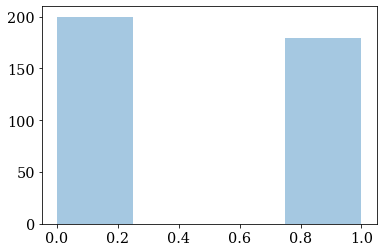

In [6]:
if outcomes_type == 'mortality':
    fig, axlist = plt.subplots(1,1)
    sns.distplot(new_dset['y_data'][new_dset['event_obs']==1],label='observed', ax = axlist, kde=False)
    sns.distplot(new_dset['y_data'][new_dset['event_obs']==0],label='censored', ax = axlist, kde=False)
    axlist.legend(fontsize=18)
    axlist.set_xlim([0,70])
elif outcomes_type == 'trt_resp': 
    fig, axlist = plt.subplots(1,1)
    sns.distplot(new_dset['y_data'], ax = axlist, kde=False)
    print(len(np.where(new_dset['y_data']==1.)[0]))

179


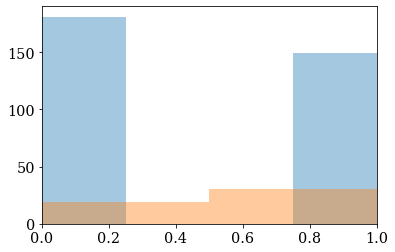

In [7]:
if outcomes_type == 'mortality':
    fig, axlist = plt.subplots(1,1)
    sns.distplot(new_dset_2mos['y_data'][new_dset_2mos['event_obs']==1],label='observed', ax = axlist, kde=False)
    sns.distplot(new_dset_2mos['y_data'][new_dset_2mos['event_obs']==0],label='censored', ax = axlist, kde=False)
    axlist.legend(fontsize=18)
    axlist.set_xlim([0,70])
elif outcomes_type == 'trt_resp': 
    fig, axlist = plt.subplots(1,1)
#     sns.distplot(new_dset_2mos['y_data'], ax = axlist, kde=False)
    sns.distplot(new_dset_2mos['y_data'][new_dset_2mos['event_obs']==1],label='observed', ax = axlist, kde=False)
    sns.distplot(new_dset_2mos['y_data'][new_dset_2mos['event_obs']==0],label='censored', ax = axlist, kde=False)
    print(len(np.where(new_dset['y_data']==1.)[0]))
    axlist.set_xlim([0,1])

### Step 2: Clean baseline values (to be in a range -7 to 7ish where 0 corresponds to reference [max])

In [8]:
# Reference values for lab measurements
# min/max/scale (calculated by attempting to ensure that max labs lie b/w 5-8)
healthy_mins_max = {
    'cbc_abs_neut':(2., 7.5,1/3.), # abs neutrophil count (3.67, 1.), (2.83, 4.51)
    'chem_albumin':(34, 50,1/8.), # chemical albumin (43.62, 2.77), (41.30, 45.94)
    'chem_bun':(2.5, 7.1,1/5.), #BUN # reference range, (4.8, 1.15)
    'chem_calcium':(2.2, 2.7,2.), #Calcium, (2.45, 0.125)
    'chem_creatinine':(66, 112,1/36.), # creatinine, (83., 24.85), (62.22, 103.77)
    'chem_glucose':(3.9, 6.9,1/5.), # glucose, (4.91, 0.40), (4.58, 5.24)
    'cbc_hemoglobin':(13., 17.,1), # hemoglobin (12.90, 15.64), (8.86, 1.02)
    'chem_ldh':(2.33, 4.67,1/3.), #LDH, (3.5, 0.585)
    'serum_m_protein':(0.1, 1.1, 1), # M protein (<3 g/dL is MGUS, any presence of protein is pathological); am just using the data mean/std for this, (0.85, 1.89)
    'urine_24hr_m_protein':(0.0, 0.1, 1), # Urine M protein 
    'cbc_platelet':(150, 400,1/60.), # platelet count (206.42, 334.57), (270.5, 76.63)
    'chem_totprot':(6, 8,1/6.), # total protein, (7, 0.5)
    'urine_24hr_total_protein':(0, 0.23, 1), # 
    'cbc_wbc':(3, 10,1/4.), # WBC  (5.71, 8.44), (7.07, 1.63)
    'serum_iga':(0.85, 4.99, 1.), # IgA, (2.92, 1.035)
    'serum_igg':(6.10, 16.16,1/10.), # IgG, (11.13, 2.515)
    'serum_igm':(0.35, 2.42,1), #IgM, (1.385, 0.518)
    'serum_lambda':(0.57, 2.63, 1/2.), #serum lambda, (1.6, 0.515)
    'serum_kappa':(.33, 1.94,1/8.), #serum kappa , (1.135, 0.403)
    'serum_beta2_microglobulin':(0.7, 1.80, 1/3.), #serum_beta2_microglobulin,
    'serum_c_reactive_protein':(0.0, 1., 1.), #serum_c_reactive_protein,
    'kl_ratio': (.26, 1.65, 1/60.), 
    'SERUMMCOMPONE': (0.,0.,1.), # don't scale the binary features 
    'URINEMCOMPONE': (0.,0.,1.),
    'ONLYINPATIENT': (0.,0.,1.), 
    'ONLYINPATIENT2': (0.,0.,1.),
    'DEVELOPMENTOF': (0.,0.,1.)
}

In [9]:
clean_baseline(new_dset, healthy_mins_max)

A] Before cleaning
idx, featurename, min, mean, max
0 iss 1.0 1.9091239340751802 3.0
1 age 27.0 64.35620052770449 93.0
2 gender 1.0 1.395778364116095 2.0
3 ecog 0.0 0.9256899548575069 4.0
4 serum_beta2_microglobulin 0.21899999999999997 5.243271392245184 22.400000000000002
5 PC1 -30.61327343 -2.0401884311043097 140.0614706
6 PC2 -33.3253597 4.2040281726060185 115.7871011
7 PC3 -52.15364387 -1.3184685734053117 51.23220332
8 PC4 -35.67956674 -1.6774510286267308 44.84930211
9 PC5 -37.58013775 -0.3282706951739725 50.21645239
10 heavy_chain False 0.8443271767810027 True
11 igg_type False 0.6174142480211082 True
12 iga_type False 0.18469656992084432 True
13 igm_type False 0.05804749340369393 True
14 kappa_type False 0.6147757255936676 True
15 lambda_type False 0.36939313984168864 True
------
------
C] After cleaning
0 iss 1.0 1.909124 3.0 False
1 age -3.59588 -5.1583967e-08 2.7572308 False
2 gender -1.0 -0.20844327 1.0 False
3 ecog -0.06536664 -1.9501256e-08 0.21708915 False
4 serum_beta2_mic

In [10]:
clean_baseline(new_dset_2mos, healthy_mins_max)

A] Before cleaning
idx, featurename, min, mean, max
0 iss 1.0 1.9091239340751802 3.0
1 age 27.0 64.35620052770449 93.0
2 gender 1.0 1.395778364116095 2.0
3 ecog 0.0 0.9256899548575069 4.0
4 serum_beta2_microglobulin 0.21899999999999997 5.243271392245184 22.400000000000002
5 PC1 -30.61327343 -2.0401884311043097 140.0614706
6 PC2 -33.3253597 4.2040281726060185 115.7871011
7 PC3 -52.15364387 -1.3184685734053117 51.23220332
8 PC4 -35.67956674 -1.6774510286267308 44.84930211
9 PC5 -37.58013775 -0.3282706951739725 50.21645239
10 heavy_chain False 0.8443271767810027 True
11 igg_type False 0.6174142480211082 True
12 iga_type False 0.18469656992084432 True
13 igm_type False 0.05804749340369393 True
14 kappa_type False 0.6147757255936676 True
15 lambda_type False 0.36939313984168864 True
------
------
C] After cleaning
0 iss 1.0 1.909124 3.0 False
1 age -3.59588 -5.1583967e-08 2.7572308 False
2 gender -1.0 -0.20844327 1.0 False
3 ecog -0.06536664 -1.9501256e-08 0.21708915 False
4 serum_beta2_mic

### Step 3: Clean time-series lab values

In [11]:
clean_labs(new_dset, healthy_mins_max)
clean_labs(new_dset_2mos, healthy_mins_max)

A] Before cleaning
idx, featurename, min, mean, max
0 cbc_abs_neut 0.0 0.7476201690188031 19.5
1 chem_albumin 0.0 8.381335736235497 52.0
2 chem_bun 0.0 1.409928459153053 33.56
3 chem_calcium 0.0 0.5085664675668766 5.6
4 chem_creatinine 0.0 22.566514534446252 433.73999999999995
5 chem_glucose 0.0 1.3852646028848583 32.775
6 cbc_hemoglobin 0.0 1.6615915727192772 11.655999999999999
7 serum_kappa 0.0 0.9662740148079817 14.649999999999999
8 serum_m_protein 0.0 0.16180461175945673 5.5
9 cbc_platelet 0.0 41.26192372271529 715.0
10 chem_totprot 0.0 1.5188187728580813 16.4
11 cbc_wbc 0.0 1.2407623730710802 29.5
12 serum_iga 0.0 0.2489211279182549 9.15
13 serum_igg 0.0 2.34343887916572 48.9
14 serum_igm 0.0 0.06703812426913838 6.387499999999999
15 serum_lambda 0.0 0.5574118385974366 11.45
------
B] Subtracting healthy max  7.5  from cbc_abs_neut  and scaling:  0.3333333333333333
B] Subtracting healthy max  50  from chem_albumin  and scaling:  0.125
B] Subtracting healthy max  7.1  from chem_bun 

### Step 4: Get censorship balanced train/test splits

In [12]:
# train_valid_folds, testidx = get_splits(new_dset['y_data'], nfolds=5)
# print()
train_valid_folds, testidx = get_splits(new_dset['event_obs'], nfolds=5)
print(testidx)
# train0, valid0 = train_valid_folds[0]
# t0 = new_dset['y_data'][train0]
# v0 = new_dset['y_data'][valid0]
# print(np.where(t0 == 1.)[0].shape)
# print(np.where(t0 == 0.)[0].shape)
# print()
# print(np.where(v0 == 1.)[0].shape)
# print(np.where(v0 == 0.)[0].shape)
# print()
# test = new_dset['y_data'][testidx]
# print(np.where(test == 1.)[0].shape)
# print(np.where(test == 0.)[0].shape)

Total:  379
Total:  283
Fold:  0 212 71
Event obs:  185 62
Total:  283
Fold:  1 212 71
Event obs:  185 62
Total:  283
Fold:  2 212 71
Event obs:  185 62
Total:  283
Fold:  3 212 71
Event obs:  185 62
Total:  283
Fold:  4 212 71
Event obs:  185 62
[212  52 207 278 190 174  67 311 359  34  13 370 338 213 208 130 322 197
  21 365 368 205  36  90 296  11 318  97  41 218  68  47  57 240 340 339
 353 139 254  72 324 147 211  25  49   0 227 361 110 201 293 105 223 107
 374 191  79  55 236 320 260 167 160 203 148 144  54 300 229  94 137 367
 113 102  92 305 134 333  66 294  35  48 119 313 376  43  61 369 145 332
  31 206 184 170 281 228]


In [13]:
if not os.path.exists('folds.pkl'):
    train_valid_folds, testidx = get_splits(new_dset['event_obs'], nfolds = 5)
    with open('folds.pkl','wb') as f:
        pickle.dump((train_valid_folds, testidx),f)
else:
    print ('Reading...')
    with open('folds.pkl','rb') as f:
        train_valid_folds, testidx = pickle.load(f)

Reading...


### Step 5: Split dataset for 5 fold CV

In [ ]:
for fold in range(5):
    print ('Saving fold ', fold)
    final_dataset = {}
    final_dataset[fold] = {}
    for tvt in ['train','valid','test']:
        if  tvt =='test':
            idx = testidx
        elif tvt =='train':
            idx = train_valid_folds[fold][0]
        elif tvt == 'valid':
            idx = train_valid_folds[fold][1]
        else:
            raise NotImplemented()
        final_dataset[fold][tvt] = {}
        final_dataset[fold][tvt]['pids']   = new_dset['patient_ids'][idx]
        # labs
        final_dataset[fold][tvt]['x']      = new_dset['labs_data_clean'][idx]
        final_dataset[fold][tvt]['m']    = new_dset['labs_m'][idx]
        final_dataset[fold][tvt]['feature_names_x']    = new_dset['labs_names']
        # outcomes
        final_dataset[fold][tvt]['ys_seq'] = new_dset['y_data'][idx].reshape(-1,1)
        final_dataset[fold][tvt]['ce']     = (1.-new_dset['event_obs'][idx]).reshape(-1,1)
        # baseline
        final_dataset[fold][tvt]['b']      = new_dset['baseline_data_clean'][idx]
        final_dataset[fold][tvt]['feature_names']    = new_dset['baseline_names']
        # treatments
        final_dataset[fold][tvt]['a']      = new_dset['treatment_data'][idx]
        final_dataset[fold][tvt]['m_a']    = new_dset['treatment_m'][idx]
        final_dataset[fold][tvt]['feature_names_a']    = new_dset['treatment_names']
    
    # Forward fill missing data in longitudinal lab tensors
    for tvt in ['train','valid','test']:
        x_new  = np.copy(final_dataset[fold][tvt]['x'])
        x_new[final_dataset[fold][tvt]['m']==0] = np.nan
        x_new_filled  = []
        for k in range(x_new.shape[-1]):
            x_new_filled.append(pd.DataFrame(x_new[...,k]).fillna(method='ffill', axis=1).values[...,None])
        x_new_filled  = np.concatenate(x_new_filled, axis=-1)
        assert not np.any(np.isnan(x_new_filled)),'should not be any nans'
        final_dataset[fold][tvt]['x'] = x_new_filled
    
    # Restrict (in train/valid set) to patients with atleast two longitudinal observations
    T_lb = 2
    for tvt in ['train']:
        M     = final_dataset[fold][tvt]['m']
        M_t   = (M.sum(-1)>1.)*1.
        all_t = M_t.sum(-1)
        keep_idx = np.argwhere(all_t>T_lb).ravel()
        if tvt == 'train':
            C = final_dataset[fold][tvt]['ce']
            print ('Before: N censored/total ',C.sum(), C.shape[0], C.sum()/C.shape[0])
        for kk in ['a','x','m','ys_seq','ce','b','pids','m_a']:
            final_dataset[fold][tvt][kk] = np.copy(final_dataset[fold][tvt][kk][keep_idx])
        if tvt == 'train':
            C = final_dataset[fold][tvt]['ce']
            print ('After: N censored/total ',C.sum(), C.shape[0], C.sum()/C.shape[0])

    with open('cleaned_mm'+str(fold)+'.pkl','wb') as f:
        pickle.dump(final_dataset, f)

In [26]:
new_dset_2mos['treatment_data'].shape

(380, 33, 6)

In [13]:
print(outcomes_type)
for fold in range(5):
    print ('Saving fold ', fold)
    final_dataset = {}
    final_dataset[fold] = {}
    for tvt in ['train','valid','test']:
        if  tvt =='test':
            idx = testidx
        elif tvt =='train':
            idx = train_valid_folds[fold][0]
        elif tvt == 'valid':
            idx = train_valid_folds[fold][1]
        else:
            raise NotImplemented()
        final_dataset[fold][tvt] = {}
        final_dataset[fold][tvt]['pids']               = new_dset_2mos['patient_ids'][idx]
        # labs
        final_dataset[fold][tvt]['x']                  = new_dset_2mos['labs_data_clean'][idx]
        final_dataset[fold][tvt]['m']                  = new_dset_2mos['labs_m'][idx]
        final_dataset[fold][tvt]['feature_names_x']    = new_dset_2mos['labs_names']
        # outcomes
        final_dataset[fold][tvt]['ys_seq'] = new_dset_2mos['y_data'][idx].reshape(-1,1)
        final_dataset[fold][tvt]['ce']     = (1.-new_dset_2mos['event_obs'][idx]).reshape(-1,1)
        if outcomes_type == 'trt_resp': 
            final_dataset[fold][tvt]['feature_names_y']    = new_dset_2mos['tr_names']
        # baseline
        final_dataset[fold][tvt]['b']      = new_dset_2mos['baseline_data_clean'][idx]
        final_dataset[fold][tvt]['feature_names']    = new_dset_2mos['baseline_names']
        # treatments
        final_dataset[fold][tvt]['a']      = new_dset_2mos['treatment_data'][idx]
        final_dataset[fold][tvt]['m_a']    = new_dset_2mos['treatment_m'][idx]
        final_dataset[fold][tvt]['feature_names_a']    = new_dset_2mos['treatment_names']
    
    # Forward fill missing data in longitudinal lab tensors
    for tvt in ['train','valid','test']:
        x_new  = np.copy(final_dataset[fold][tvt]['x'])
        x_new[final_dataset[fold][tvt]['m']==0] = np.nan
        x_new_filled  = []
        for k in range(x_new.shape[-1]):
            x_new_filled.append(pd.DataFrame(x_new[...,k]).fillna(method='ffill', axis=1).values[...,None])
        x_new_filled  = np.concatenate(x_new_filled, axis=-1)
        assert not np.any(np.isnan(x_new_filled)),'should not be any nans'
        final_dataset[fold][tvt]['x'] = x_new_filled
    
    # Restrict (in train/valid set) to patients with atleast two longitudinal observations
    T_lb = 2
    print(f'train...')
    for tvt in ['train']:
        M     = final_dataset[fold][tvt]['m']
        M_t   = (M.sum(-1)>1.)*1.
        all_t = M_t.sum(-1)
        keep_idx = np.argwhere(all_t>T_lb).ravel()
        if tvt == 'train':
            if outcomes_type == 'mortality':
                C = final_dataset[fold][tvt]['ce']
                print ('Before: N censored/total ',C.sum(), C.shape[0], C.sum()/C.shape[0])
            elif outcomes_type == 'trt_resp': 
                Y = final_dataset[fold][tvt]['ys_seq']
                C = final_dataset[fold][tvt]['ce']
                print ('Before: N censored/total ',C.sum(), C.shape[0], C.sum()/C.shape[0])
                for i in range(np.max(Y)+1): 
                    print (f'Before: Y class {i}, N: {len(np.where(Y == i)[0])}')
        for kk in ['a','x','m','ys_seq','ce','b','pids','m_a']:
            final_dataset[fold][tvt][kk] = np.copy(final_dataset[fold][tvt][kk][keep_idx])
        if tvt == 'train':
            if outcomes_type == 'mortality':
                C = final_dataset[fold][tvt]['ce']
                print ('After: N censored/total ',C.sum(), C.shape[0], C.sum()/C.shape[0])
            elif outcomes_type == 'trt_resp': 
                Y = final_dataset[fold][tvt]['ys_seq']
                C = final_dataset[fold][tvt]['ce']
                print ('After: N censored/total ',C.sum(), C.shape[0], C.sum()/C.shape[0])
                for i in range(np.max(Y)+1): 
                    print (f'After: Y class {i}, N: {len(np.where(Y == i)[0])}')
    print (final_dataset[fold]['train']['x'].shape)
    for tvt in ['valid', 'test']: 
        print(f'{tvt}...')
        if outcomes_type == 'mortality':
            C = final_dataset[fold][tvt]['ce']
            print ('Before: N censored/total ',C.sum(), C.shape[0], C.sum()/C.shape[0])
        elif outcomes_type == 'trt_resp': 
            Y = final_dataset[fold][tvt]['ys_seq']
            C = final_dataset[fold][tvt]['ce']
            print ('Before: N censored/total ',C.sum(), C.shape[0], C.sum()/C.shape[0])
            for i in range(np.max(Y)+1): 
                print (f'Before: Y class {i}, N: {len(np.where(Y == i)[0])}')
    print()
    with open('cleaned_mm'+str(fold)+'_2mos_tr_ia15.pkl','wb') as f:
        pickle.dump(final_dataset, f)

trt_resp
Saving fold  0
train...
Before: N censored/total  27.0 212 0.12735849056603774
Before: Y class 0, N: 114
Before: Y class 1, N: 98
After: N censored/total  27.0 212 0.12735849056603774
After: Y class 0, N: 114
After: Y class 1, N: 98
(212, 36, 16)
valid...
Before: N censored/total  9.0 71 0.1267605633802817
Before: Y class 0, N: 41
Before: Y class 1, N: 30
test...
Before: N censored/total  13.0 96 0.13541666666666666
Before: Y class 0, N: 45
Before: Y class 1, N: 51

Saving fold  1
train...
Before: N censored/total  27.0 212 0.12735849056603774
Before: Y class 0, N: 119
Before: Y class 1, N: 93
After: N censored/total  27.0 212 0.12735849056603774
After: Y class 0, N: 119
After: Y class 1, N: 93
(212, 36, 16)
valid...
Before: N censored/total  9.0 71 0.1267605633802817
Before: Y class 0, N: 36
Before: Y class 1, N: 35
test...
Before: N censored/total  13.0 96 0.13541666666666666
Before: Y class 0, N: 45
Before: Y class 1, N: 51

Saving fold  2
train...
Before: N censored/total 